In [ ]:

# THIS IS THE FIRST VERSION OF CGENERATOR AND CDISCRIMINATOR-------THERE ARE A LOT OF NECESARY UPGRADES
#VERSION 1.0

import os ,torch
import torch.nn  as nn
import torch.optim  as optim
from torchvision  import datasets , transforms
from torchvision.utils import save_image
from torch.utils.data  import DataLoader
from google.colab import drive


import time


drive.mount('/content/drive' )

ruta = "/content/drive/MyDrive/Neural Networks/Proyecto"
ruta_guardado = os.path.join(ruta ,"generadas_cgan")

if not os.path.exists(ruta_guardado  ):
 os.makedirs(ruta_guardado )

!cp -r "/content/drive/MyDrive/Neural Networks/Proyecto/train" /content/train

!ls /content/train


dispo = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu")
print("Dispositivo:",dispo)


TAM_IMG = 48
z_dim = 93
n_etiquetas =7
bs= 128
epocas = 200



to_gray=transforms.Grayscale(1)
resize =transforms.Resize((TAM_IMG ,TAM_IMG ))
to_tensor = transforms.ToTensor()
norm = transforms.Normalize([0.5] ,[0.5] )

data_tf =transforms.Compose([to_gray ,resize ,to_tensor ,norm ])


ruta_data = "/content/train"



#print("1")
trainset = datasets.ImageFolder(ruta_data ,transform=data_tf )
loader = DataLoader(trainset ,batch_size = bs ,shuffle =True  )
#print("2")


class Generador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas ,z_dim )
  self.etq_extra = nn.Linear( z_dim,z_dim )
  self.conv_layers = [None ,None ,None]
  self.bn1= nn.BatchNorm2d(504)
  self.bn2= nn.BatchNorm2d(248)
  self.bn3= nn.BatchNorm2d(127)
  self.final= nn.ConvTranspose2d(127,1,4 ,3,1)

 def forward(self,z ,y ):

  if z.shape[1] !=z_dim:
    print("Algo raro pasa con z_dim",z.shape)

  y_emb=self.etq(y)
  y2 =torch.relu(self.etq_extra(y_emb) )
  x =torch.cat([z,y2] ,dim=1 )
  x =x.view(x.size(0),x.size(1),1,1)

  if self.conv_layers[0] is None:
    self.conv_layers[0]= nn.ConvTranspose2d(186 ,504,4 ,1,0).to(x.device)
    self.conv_layers[1]= nn.ConvTranspose2d(504 ,248,4 ,2 ,1).to(x.device)
    self.conv_layers[2] =nn.ConvTranspose2d(248,127,4 ,2 ,1).to(x.device)

  x= torch.relu(self.bn1(self.conv_layers[0](x)))
  x= torch.relu( self.bn2(self.conv_layers[1](x)))
  x =torch.relu(self.bn3(self.conv_layers[2](x)))
  x = self.final(x)

  return torch.tanh(x)



class Discriminador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding( n_etiquetas , TAM_IMG * TAM_IMG )
  self.conv1 = nn.Conv2d(2 ,127,4 ,2 ,1)
  self.act1 =nn.LeakyReLU(0.2)
  self.conv2= nn.Conv2d(127 ,251 ,4,2 ,1)
  self.bn2 =nn.BatchNorm2d(251)
  self.act2= nn.LeakyReLU(0.2)
  self.conv3= nn.Conv2d(251 ,507 ,4 ,2 ,1)
  self.bn3=nn.BatchNorm2d(507)
  self.act3= nn.LeakyReLU(0.2)
  self.final= nn.Conv2d(507 ,1 ,6)

 def forward(self ,x ,etiqueta ):

  if x.shape[2:] != (TAM_IMG ,TAM_IMG):
    x = nn.functional.interpolate( x ,size=(TAM_IMG ,TAM_IMG ),mode='bilinear')

  ymap=self.etq(etiqueta ).view( -1 ,1,TAM_IMG ,TAM_IMG )
  inp =torch.cat([x ,ymap] ,dim=1)

  x= self.conv1(inp)
  x= self.act1(x)
  x =self.conv2(x)
  x= self.bn2(x)
  x =self.act2(x)
  x=self.conv3(x)
  x =self.bn3(x)
  x =self.act3(x)
  x= self.final(x)
  return torch.sigmoid( x.view( -1 ))


print("Models has been iniciated")

G =Generador().to( dispo)
D= Discriminador().to( dispo )

opt_G =optim.Adam( G.parameters() ,lr = 0.00018,betas=( 0.45 ,0.98 ) )       #i think the main problem is that a choose a very low lr and the nn are not learning nothing

opt_D= optim.Adam( D.parameters() ,lr = 0.00018 ,betas=( 0.45 ,0.98 ) )

#print("3")

criterio = nn.BCELoss()



print( f"training is started, total epoch: {epocas}")



for ep in range( epocas ):
 t0 = time.time()
 print(f" empezando época {ep+1}")
 for idx , (reales ,clases ) in enumerate( loader ):
  if idx == 0:
    #print("4")
  reales =reales.to( dispo )
  clases=clases.to( dispo )
  tam= reales.size(0)

  unos = torch.ones(tam ,device =dispo )
  ceros = torch.zeros(tam,device =dispo)

  z = torch.randn(tam ,z_dim , device =dispo)
  #print("5")
  fakez= G(z ,clases)
  #print("6")
  out_real=D(reales,clases)
  #print("7")
  out_fake =D(fakez.detach() ,clases)
  #print("8")

  lossD= criterio( out_real,unos ) +criterio(out_fake ,ceros )

  opt_D.zero_grad()
  lossD.backward()
  opt_D.step()
  #print("9")

  if idx % 2 ==0 or lossD.item()<1.3:
    out_fake_2 = D( fakez ,clases )
    lossG = criterio( out_fake_2 , unos)
    opt_G.zero_grad()
    lossG.backward()
    opt_G.step()
    #print("9")
  if idx % 49== 0:
    print( f"Epoca {ep+1} | Batch {idx} | LD {lossD.item():.4f} | LG {lossG.item():.4f}" )

 if (ep + 1) % 10 == 0:
  t1 = time.time()
  print(f"time for the epoch {ep+1}: {t1 - t0:.2f} secondss")

  with torch.no_grad():
    test_z =torch.randn( n_etiquetas ,z_dim ,device=dispo )
    test_y=torch.arange( n_etiquetas ,device =dispo )
    muestras= G(test_z ,test_y )
    save_image( muestras,f"{ruta_guardado}/ep_{ep+1}.png",nrow=7 ,normalize=True )
    print(f"Saved files from epoch {ep+1}" )


torch.save( G.state_dict(), os.path.join(ruta , "generador_final_cgan_human.pth" ) )
torch.save( D.state_dict(), os.path.join(ruta ,"discriminador_final_cgan_human.pth" ) )

print("all done,not chash so its suscesfull")


Se han truncado las últimas 5000 líneas del flujo de salida.
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
Epoca 197 | Batch 49 | LD 3.9062 | LG 23.8597
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
Epoca 197 | Batch 98 | LD 3.1250 | LG 37.3838
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
5
6
7
8
9
9
5
6
7
8
9
9
5
6
7
8
9
9
5
6
7
8
9
5
6

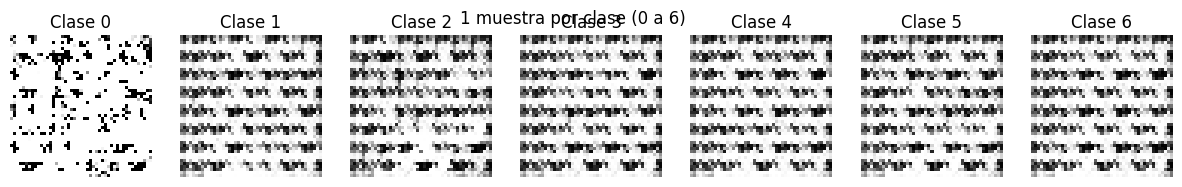

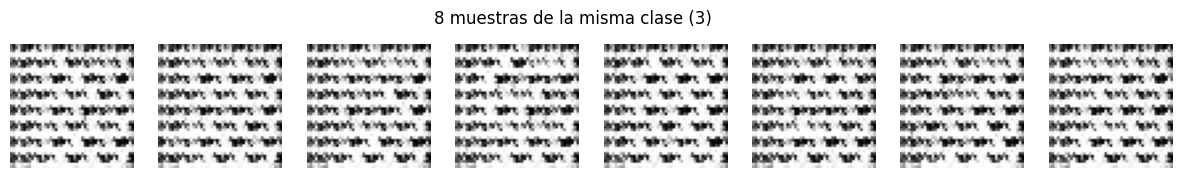

In [ ]:
#segundo entrenamiento

#VERSION 1.1


import os ,torch
import torch.nn  as nn
import torch.optim  as optim
from torchvision  import datasets , transforms
from torchvision.utils import save_image
from torch.utils.data  import DataLoader
from google.colab import drive


import time


drive.mount('/content/drive' )

ruta = "/content/drive/MyDrive/Neural Networks/Proyecto"
ruta_guardado = os.path.join(ruta ,"generadas_cgan")

if not os.path.exists(ruta_guardado  ):
 os.makedirs(ruta_guardado )

!cp -r "/content/drive/MyDrive/Neural Networks/Proyecto/train" /content/train

!ls /content/train


dispo = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu")
print("Dispositivo:",dispo)


TAM_IMG = 48
z_dim = 93
n_etiquetas =7
bs= 128
epocas = 200



to_gray=transforms.Grayscale(1)
resize =transforms.Resize((TAM_IMG ,TAM_IMG ))
to_tensor = transforms.ToTensor()
norm = transforms.Normalize([0.5] ,[0.5] )

data_tf =transforms.Compose([to_gray ,resize ,to_tensor ,norm ])


ruta_data = "/content/train"



#print("1")
trainset = datasets.ImageFolder(ruta_data ,transform=data_tf )
loader = DataLoader(trainset ,batch_size = bs ,shuffle =True  )
#print("2")


class Generador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas ,z_dim )
  self.etq_extra = nn.Linear( z_dim,z_dim )
  self.conv_layers = [None ,None ,None]
  self.bn1= nn.BatchNorm2d(504)
  self.bn2= nn.BatchNorm2d(248)
  self.bn3= nn.BatchNorm2d(127)
  self.final= nn.ConvTranspose2d(127,1,4 ,3,1)

 def forward(self,z ,y ):

  if z.shape[1] !=z_dim:
    print("Algo raro pasa con z_dim",z.shape)

  y_emb=self.etq(y)
  y2 =torch.relu(self.etq_extra(y_emb) )
  x =torch.cat([z,y2] ,dim=1 )
  x =x.view(x.size(0),x.size(1),1,1)

  if self.conv_layers[0] is None:
    self.conv_layers[0]= nn.ConvTranspose2d(186 ,504,4 ,1,0).to(x.device)
    self.conv_layers[1]= nn.ConvTranspose2d(504 ,248,4 ,2 ,1).to(x.device)
    self.conv_layers[2] =nn.ConvTranspose2d(248,127,4 ,2 ,1).to(x.device)

  x= torch.relu(self.bn1(self.conv_layers[0](x)))
  x= torch.relu( self.bn2(self.conv_layers[1](x)))
  x =torch.relu(self.bn3(self.conv_layers[2](x)))
  x = self.final(x)

  return torch.tanh(x)



class Discriminador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding( n_etiquetas , TAM_IMG * TAM_IMG )
  self.conv1 = nn.Conv2d(2 ,127,4 ,2 ,1)
  self.act1 =nn.LeakyReLU(0.2)
  self.conv2= nn.Conv2d(127 ,251 ,4,2 ,1)
  self.bn2 =nn.BatchNorm2d(251)
  self.act2= nn.LeakyReLU(0.2)
  self.conv3= nn.Conv2d(251 ,507 ,4 ,2 ,1)
  self.bn3=nn.BatchNorm2d(507)
  self.act3= nn.LeakyReLU(0.2)
  self.final= nn.Conv2d(507 ,1 ,6)

 def forward(self ,x ,etiqueta ):

  if x.shape[2:] != (TAM_IMG ,TAM_IMG):
    x = nn.functional.interpolate( x ,size=(TAM_IMG ,TAM_IMG ),mode='bilinear')

  ymap=self.etq(etiqueta ).view( -1 ,1,TAM_IMG ,TAM_IMG )
  inp =torch.cat([x ,ymap] ,dim=1)

  x= self.conv1(inp)
  x= self.act1(x)
  x =self.conv2(x)
  x= self.bn2(x)
  x =self.act2(x)
  x=self.conv3(x)
  x =self.bn3(x)
  x =self.act3(x)
  x= self.final(x)
  return torch.sigmoid( x.view( -1 ))


print("Models has been iniciated")

G =Generador().to( dispo)
D= Discriminador().to( dispo )

opt_G =optim.Adam( G.parameters() ,lr = 0.0002,betas=( 0.5 ,0.999 ) )
opt_D= optim.Adam( D.parameters() ,lr = 0.0002 ,betas=( 0.5 ,0.999 ) )

#print("3")

criterio = nn.BCELoss()



print( f"training is started, total epoch: {epocas}")

#i relized that i put some names in spanish, i will change it in the next version
#tomorrow i have to oresent to you so i will coment some things so you understand whats happening

for ep in range( epocas ):
 t0 = time.time()
 print(f" empezando época {ep+1}")
 for idx , (reales ,clases ) in enumerate( loader ):
  #if idx == 0:
    #print("4")
  reales =reales.to( dispo )  #real images from dataset
  clases=clases.to( dispo )   #labels from 0 to 6
  tam= reales.size(0)

  unos = torch.ones(tam ,device =dispo )  #objetive to say the discriminator one image is real
  ceros = torch.zeros(tam,device =dispo) #same but false

  z = torch.randn(tam ,z_dim , device =dispo) #aleatory vector for the generator
  #print("5")
  fakez= G(z ,clases)#fake images generated
  #print("6")

  for _ in range(2):
    out_real=D(reales,clases)
    out_fake =D(fakez.detach() ,clases)
    lossD= criterio( out_real,unos ) +criterio(out_fake ,ceros)
    opt_D.zero_grad()
    lossD.backward()
    opt_D.step()
  #print("9")

  if idx % 2 ==0 or lossD.item()<1.3:
    out_fake_2 = D( fakez ,clases )
    lossG = criterio( out_fake_2 , unos)
    opt_G.zero_grad()
    lossG.backward()
    opt_G.step()
    #print("9")
  if idx % 49== 0:
    print( f"Epoca {ep+1} | Batch {idx} | LD {lossD.item():.4f} | LG {lossG.item():.4f}" )

 if (ep + 1) % 10 == 0:
  t1 = time.time()
  print(f"time for the epoch {ep+1}: {t1 - t0:.2f} secondss")

  with torch.no_grad():
    test_z =torch.randn( n_etiquetas ,z_dim ,device=dispo )
    test_y=torch.arange( n_etiquetas ,device =dispo )
    muestras= G(test_z ,test_y )
    save_image( muestras,f"{ruta_guardado}/ep_{ep+1}.png",nrow=7 ,normalize=True )
    print(f"Saved files from epoch {ep+1}" )


torch.save( G.state_dict(), os.path.join(ruta , "generador_final_cgan_human.pth" ) )
torch.save( D.state_dict(), os.path.join(ruta ,"discriminador_final_cgan_human.pth" ) )

print("all done,not chash so its suscesfull")


Mounted at /content/drive
0  1  2  3  4  5  6
Dispositivo: cuda
Models has been iniciated
training is started, total epoch: 200
 empezando época 1
Epoca 1 | Batch 0 | LD 1.0000 | LG 1.3481
Epoca 1 | Batch 49 | LD 0.0048 | LG 6.8340
Epoca 1 | Batch 98 | LD 0.0007 | LG 8.6495
Epoca 1 | Batch 147 | LD 0.0003 | LG 9.4173
Epoca 1 | Batch 196 | LD 0.0007 | LG 8.9771
 empezando época 2
Epoca 2 | Batch 0 | LD 0.0004 | LG 9.7309
Epoca 2 | Batch 49 | LD 0.0002 | LG 9.8565
Epoca 2 | Batch 98 | LD 0.0001 | LG 10.3829
Epoca 2 | Batch 147 | LD 0.0001 | LG 10.3000
Epoca 2 | Batch 196 | LD 0.0001 | LG 10.9717
 empezando época 3
Epoca 3 | Batch 0 | LD 0.0001 | LG 10.9442
Epoca 3 | Batch 49 | LD 0.0001 | LG 10.6779
Epoca 3 | Batch 98 | LD 0.0001 | LG 11.2526
Epoca 3 | Batch 147 | LD 0.0001 | LG 10.6030
Epoca 3 | Batch 196 | LD 0.0001 | LG 10.9971
 empezando época 4
Epoca 4 | Batch 0 | LD 0.0000 | LG 11.5008
Epoca 4 | Batch 49 | LD 0.0000 | LG 12.1261
Epoca 4 | Batch 98 | LD 0.0000 | LG 12.2507
Epoca 4 |

In [ ]:
#Version 1.2
#UPGRADES FROM LAST VERSION


# go from 504 → 248 → 127 → 1) to 1024 → 512 → 256 → 128 → 1

#z_dim FROM 93 to maybe 128

# Delete "nn.ConvTranspose2d(127,1, kernel=4, stride=3, padding=1)" and generate 48x48 images, not resize





import os ,torch
import torch.nn  as nn
import torch.optim  as optim
from torchvision  import datasets , transforms
from torchvision.utils import save_image
from torch.utils.data  import DataLoader
from google.colab import drive

import time


drive.mount('/content/drive' )

ruta = "/content/drive/MyDrive/Neural Networks/Proyecto"
ruta_guardado = os.path.join(ruta ,"generadas_cgan")

if not os.path.exists(ruta_guardado  ):
 os.makedirs(ruta_guardado )

!cp -r "/content/drive/MyDrive/Neural Networks/Proyecto/train" /content/train

!ls /content/train


dispo = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu")
print("Dispositivo:",dispo)


TAM_IMG = 48
z_dim =128
n_etiquetas =7
bs= 128
epocas = 200


to_gray=transforms.Grayscale(1)
resize =transforms.Resize((TAM_IMG ,TAM_IMG ))
to_tensor = transforms.ToTensor()
norm = transforms.Normalize([0.5] ,[0.5] )

data_tf =transforms.Compose([to_gray ,resize ,to_tensor ,norm ])

ruta_data = "/content/train"

trainset = datasets.ImageFolder(ruta_data ,transform=data_tf )
loader = DataLoader(trainset ,batch_size = bs ,shuffle =True  )



class Generador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, z_dim)
  self.etq_extra = nn.Linear(z_dim, z_dim)
  self.proyector = nn.Linear(z_dim * 2, 1024 * 3 * 3)
  self.bn1= nn.BatchNorm2d(512)
  self.bn2= nn.BatchNorm2d(256)
  self.bn3= nn.BatchNorm2d(128)
  self.conv_layers = [None,None,None, None]

 def forward(self,z,y):
  if z.shape[1] !=z_dim:
    print("Algo raro pasa con z_dim",z.shape)

  y_emb = self.etq(y)
  y2 =torch.relu(self.etq_extra(y_emb))
  x =torch.cat([z, y2], dim=1)
  x =self.proyector(x).view(-1, 1024, 3, 3)

  if self.conv_layers[0] is None:
   self.conv_layers[0]= nn.ConvTranspose2d(1024,512, 4, 2, 1).to(x.device)
   self.conv_layers[1]= nn.ConvTranspose2d(512, 256, 4,2, 1).to(x.device)
   self.conv_layers[2] =nn.ConvTranspose2d(256, 128,4, 2,1).to(x.device)
   self.conv_layers[3]= nn.ConvTranspose2d(128,1, 4, 2, 1).to(x.device)

  x = torch.relu(self.bn1(self.conv_layers[0](x)))
  x = torch.relu(self.bn2(self.conv_layers[1](x)))
  x = torch.relu(self.bn3(self.conv_layers[2](x)))
  x = torch.tanh(self.conv_layers[3](x))
  return x


class Discriminador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, TAM_IMG * TAM_IMG)
  self.conv1 = nn.Conv2d(2, 256, 4,2, 1)
  self.bn1 =nn.BatchNorm2d(256)
  self.act1 = nn.LeakyReLU(0.2)
  self.conv2 = nn.Conv2d(256, 512, 4, 2,1)
  self.bn2 = nn.BatchNorm2d(512)
  self.act2= nn.LeakyReLU(0.2)
  self.conv3= nn.Conv2d(512, 1024,4, 2, 1)
  self.bn3= nn.BatchNorm2d(1024)
  self.act3=nn.LeakyReLU(0.2)
  self.final = nn.Conv2d(1024, 1,6)

 def forward(self, x, etiqueta):
  if x.shape[2:] != (TAM_IMG, TAM_IMG):
   x =nn.functional.interpolate(x, size=(TAM_IMG, TAM_IMG), mode='bilinear')

  ymap=self.etq(etiqueta).view(-1, 1, TAM_IMG, TAM_IMG)
  inp =torch.cat([x, ymap],dim=1)

  x= self.act1(self.bn1(self.conv1(inp)))
  x=self.act2(self.bn2(self.conv2(x)))
  x=self.act3(self.bn3(self.conv3(x)))
  x =self.final(x)

  return torch.sigmoid(x.view(-1))










print("Models has been iniciated")

G = Generador().to(dispo)
D = Discriminador().to(dispo)

opt_G =optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999 ) )
opt_D= optim.Adam(D.parameters(),lr=0.0002, betas=(0.5, 0.999 ) )

criterio = nn.BCELoss()

print(f"training is started, total epoch: {epocas}")



#i relized that i put some names in spanish, i will change it in the next version
#tomorrow i have to oresent to you so i will coment some things so you understand whats happening

for ep in range( epocas ):
 t0 = time.time()
 print(f" empezando época {ep+1}")
 for idx , (reales ,clases ) in enumerate( loader ):
  #if idx == 0:
    #print("4")
  reales =reales.to( dispo )  #real images from dataset
  clases=clases.to( dispo )   #labels from 0 to 6
  tam= reales.size(0)


#-------------------changed, i stoped the execution 9 hours after the begin because discriminator is too powefull
  #unos = torch.ones(tam ,device =dispo )  #objetive to say the discriminator one image is real
  #ceros = torch.zeros(tam,device =dispo) #same but false
  unos= torch.full((tam,), 0.9, device=dispo)
  ceros =torch.full((tam,), 0.1, device=dispo)




  z = torch.randn(tam ,z_dim , device =dispo) #aleatory vector for the generator
  #print("5")
  fakez= G(z ,clases)#fake images generated
  #print("6")


#----------changed too, only one discriminator training
  for _ in range(1):
    out_real=D(reales,clases)
    out_fake =D(fakez.detach() ,clases)
    lossD= criterio( out_real,unos ) +criterio(out_fake ,ceros)
    opt_D.zero_grad()
    lossD.backward()
    opt_D.step()
  #print("9")

  if idx % 2 ==0 or lossD.item()<1.3:
    out_fake_2 = D( fakez ,clases )
    lossG = criterio( out_fake_2 , unos)
    opt_G.zero_grad()
    lossG.backward()
    opt_G.step()
    #print("9")
  if idx % 49== 0:
    print( f"Epoca {ep+1} | Batch {idx} | LD {lossD.item():.4f} | LG {lossG.item():.4f}" )

 if (ep + 1) % 10 == 0:
  t1 = time.time()
  print(f"time for the epoch {ep+1}: {t1 - t0:.2f} secondss")

  with torch.no_grad():
    test_z =torch.randn( n_etiquetas ,z_dim ,device=dispo )
    test_y=torch.arange( n_etiquetas ,device =dispo )
    muestras= G(test_z ,test_y )
    save_image( muestras,f"{ruta_guardado}/ep_{ep+1}.png",nrow=7 ,normalize=True )
    print(f"Saved files from epoch {ep+1}" )


torch.save( G.state_dict(), os.path.join(ruta , "generador_final_cgan_human.pth" ) )
torch.save( D.state_dict(), os.path.join(ruta ,"discriminador_final_cgan_human.pth" ) )

print("all done,not chash so its suscesfull")



Mounted at /content/drive
0  1  2  3  4  5  6
Dispositivo: cuda
Models has been iniciated
training is started, total epoch: 200
 empezando época 1
Epoca 1 | Batch 0 | LD 1.3761 | LG 8.0719
Epoca 1 | Batch 49 | LD 0.7304 | LG 1.3432
Epoca 1 | Batch 98 | LD 0.7250 | LG 2.1149
Epoca 1 | Batch 147 | LD 0.7109 | LG 2.6795
Epoca 1 | Batch 196 | LD 0.6975 | LG 2.5406
 empezando época 2
Epoca 2 | Batch 0 | LD 0.6858 | LG 2.4334
Epoca 2 | Batch 49 | LD 0.6915 | LG 1.6879
Epoca 2 | Batch 98 | LD 0.6653 | LG 2.2618
Epoca 2 | Batch 147 | LD 0.7098 | LG 2.4979
Epoca 2 | Batch 196 | LD 0.7584 | LG 2.3250
 empezando época 3
Epoca 3 | Batch 0 | LD 0.6834 | LG 2.3507
Epoca 3 | Batch 49 | LD 0.7716 | LG 2.4390
Epoca 3 | Batch 98 | LD 0.6669 | LG 2.5167
Epoca 3 | Batch 147 | LD 0.6622 | LG 2.0817
Epoca 3 | Batch 196 | LD 0.6636 | LG 2.5302
 empezando época 4
Epoca 4 | Batch 0 | LD 0.8915 | LG 3.6992
Epoca 4 | Batch 49 | LD 0.6549 | LG 2.1041
Epoca 4 | Batch 98 | LD 0.6738 | LG 2.5823
Epoca 4 | Batch 147 

In [ ]:
# Version 1.3
# UPGRADES From last version

# 1   Ampliate the size of the initial projection in the generator 3x3 → 6x6
# 2 Reinforced the weight of the embided label : y2*2
# 3 Dropout
# 4 Changing label smoothing: reales 0.9 → 0.95 y falsas 0.1 → 0.05
# 5 Some data augmentation like rotación, flip y bright/contrast ramdom



import os ,torch
import torch.nn  as nn
import torch.optim  as optim
from torchvision  import datasets , transforms
from torchvision.utils import save_image
from torch.utils.data  import DataLoader
from google.colab import drive

import time


drive.mount('/content/drive' )

ruta = "/content/drive/MyDrive/Neural Networks/Proyecto"
ruta_guardado = os.path.join(ruta ,"generadas_cgan")

if not os.path.exists(ruta_guardado  ):
 os.makedirs(ruta_guardado )

!cp -r "/content/drive/MyDrive/Neural Networks/Proyecto/train" /content/train

!ls /content/train


dispo = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu")
print("Dispositivo:",dispo)


TAM_IMG = 48
z_dim =128
n_etiquetas =7
bs= 128
epocas = 200


to_gray=transforms.Grayscale(1)
resize =transforms.Resize((TAM_IMG ,TAM_IMG ))
to_tensor = transforms.ToTensor()
norm = transforms.Normalize([0.5] ,[0.5] )

data_tf = transforms.Compose([transforms.Grayscale(1),transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness =0.2,contrast=0.2),transforms.Resize((TAM_IMG ,TAM_IMG)),
  transforms.RandomRotation(10),transforms.ToTensor(),transforms.Normalize([0.5],[0.5])
])


ruta_data = "/content/train"

trainset = datasets.ImageFolder(ruta_data ,transform=data_tf )
loader = DataLoader(trainset ,batch_size = bs ,shuffle =True  )



class Generador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, z_dim)
  self.etq_extra = nn.Linear(z_dim, z_dim)
  self.proyector = nn.Linear(z_dim * 2, 1024 * 6 * 6)
  self.bn1= nn.BatchNorm2d(512)
  self.bn2= nn.BatchNorm2d(256)
  self.bn3= nn.BatchNorm2d(128)
  self.dropout = nn.Dropout(0.3)
  self.conv_layers = [None,None,None, None]

 def forward(self,z,y):
  if z.shape[1] !=z_dim:
    print("Algo raro pasa con z_dim",z.shape)

  y_emb = self.etq(y)
  y2 =torch.relu(self.etq_extra(y_emb))
  x = torch.cat([z, y2 * 2.0], dim=1)
  x = self.proyector(x).view(-1, 1024, 6, 6)

  if self.conv_layers[0] is None:
   self.conv_layers[0]= nn.ConvTranspose2d(1024,512, 4, 2, 1).to(x.device)
   self.conv_layers[1]= nn.ConvTranspose2d(512, 256, 4,2, 1).to(x.device)
   self.conv_layers[2] =nn.ConvTranspose2d(256, 128,4, 2,1).to(x.device)
   self.conv_layers[3]= nn.ConvTranspose2d(128,1, 4, 2, 1).to(x.device)

  x= self.dropout(torch.relu(self.bn1(self.conv_layers[0](x))))
  x =self.dropout(torch.relu(self.bn2(self.conv_layers[1](x))))
  x= self.dropout(torch.relu(self.bn3(self.conv_layers[2](x))))

  x = torch.tanh(self.conv_layers[3](x))
  return x


class Discriminador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, TAM_IMG * TAM_IMG)
  self.conv1 = nn.Conv2d(2, 256, 4,2, 1)
  self.bn1 =nn.BatchNorm2d(256)
  self.act1 = nn.LeakyReLU(0.2)
  self.conv2 = nn.Conv2d(256, 512, 4, 2,1)
  self.bn2 = nn.BatchNorm2d(512)
  self.act2= nn.LeakyReLU(0.2)
  self.conv3= nn.Conv2d(512, 1024,4, 2, 1)
  self.bn3= nn.BatchNorm2d(1024)
  self.act3=nn.LeakyReLU(0.2)
  self.final = nn.Conv2d(1024, 1,6)

 def forward(self, x, etiqueta):
  if x.shape[2:] != (TAM_IMG, TAM_IMG):
   x =nn.functional.interpolate(x, size=(TAM_IMG, TAM_IMG), mode='bilinear')

  ymap=self.etq(etiqueta).view(-1, 1, TAM_IMG, TAM_IMG)
  inp =torch.cat([x, ymap],dim=1)

  x= self.act1(self.bn1(self.conv1(inp)))
  x=self.act2(self.bn2(self.conv2(x)))
  x=self.act3(self.bn3(self.conv3(x)))
  x =self.final(x)

  return torch.sigmoid(x.view(-1))










print("Models has been iniciated")

G = Generador().to(dispo)
D = Discriminador().to(dispo)

opt_G =optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999 ) )
opt_D= optim.Adam(D.parameters(),lr=0.0002, betas=(0.5, 0.999 ) )

criterio = nn.BCELoss()

print(f"training is started, total epoch: {epocas}")



#i relized that i put some names in spanish, i will change it in the next version
#tomorrow i have to oresent to you so i will coment some things so you understand whats happening

for ep in range( epocas ):
 t0 = time.time()
 print(f" empezando época {ep+1}")
 for idx , (reales ,clases ) in enumerate( loader ):
  #if idx == 0:
    #print("4")
  reales =reales.to( dispo )  #real images from dataset
  clases=clases.to( dispo )   #labels from 0 to 6
  tam= reales.size(0)


#-------------------changed, i stoped the execution 9 hours after the begin because discriminator is too powefull
  #unos = torch.ones(tam ,device =dispo )  #objetive to say the discriminator one image is real
  #ceros = torch.zeros(tam,device =dispo) #same but false
  unos= torch.full((tam,), 0.95, device=dispo)
  ceros =torch.full((tam,), 0.05, device=dispo)




  z = torch.randn(tam ,z_dim , device =dispo) #aleatory vector for the generator
  #print("5")
  fakez= G(z ,clases)#fake images generated




  for _ in range(1):
    out_real=D(reales,clases)
    out_fake =D(fakez.detach() ,clases)
    lossD= criterio( out_real,unos ) +criterio(out_fake ,ceros)
    opt_D.zero_grad()
    lossD.backward()
    opt_D.step()


  if idx % 2 ==0 or lossD.item()<1.3:
    out_fake_2 = D( fakez ,clases )
    lossG = criterio( out_fake_2 , unos)
    opt_G.zero_grad()
    lossG.backward()
    opt_G.step()

  if idx % 49== 0:
    print( f"Epoca {ep+1} | Batch {idx} | LD {lossD.item():.4f} | LG {lossG.item():.4f}" )

 if (ep + 1) % 10 == 0:
  t1 = time.time()
  print(f"time for the epoch {ep+1}: {t1 - t0:.2f} secondss")

  with torch.no_grad():
    test_z =torch.randn( n_etiquetas ,z_dim ,device=dispo )
    test_y=torch.arange( n_etiquetas ,device =dispo )
    muestras= G(test_z ,test_y )
    save_image( muestras,f"{ruta_guardado}/ep_{ep+1}.png",nrow=7 ,normalize=True )
    print(f"Saved files from epoch {ep+1}" )


torch.save( G.state_dict(), os.path.join(ruta , "generador_final_cgan_human.pth" ) )
torch.save( D.state_dict(), os.path.join(ruta ,"discriminador_final_cgan_human.pth" ) )

print("all done,not chash so its suscesfull")



Mounted at /content/drive
0  1  2  3  4  5  6
Dispositivo: cuda
Models has been iniciated
training is started, total epoch: 200
 empezando época 1
Epoca 1 | Batch 0 | LD 1.3782 | LG 8.8799
Epoca 1 | Batch 49 | LD 0.5081 | LG 2.9098
Epoca 1 | Batch 98 | LD 0.5465 | LG 2.1791
Epoca 1 | Batch 147 | LD 0.4308 | LG 2.4603
Epoca 1 | Batch 196 | LD 0.4150 | LG 3.2882
 empezando época 2
Epoca 2 | Batch 0 | LD 0.5172 | LG 3.5366
Epoca 2 | Batch 49 | LD 0.4622 | LG 2.9767
Epoca 2 | Batch 98 | LD 0.4797 | LG 3.4065
Epoca 2 | Batch 147 | LD 0.5084 | LG 4.0445
Epoca 2 | Batch 196 | LD 0.4328 | LG 3.3168
 empezando época 3
Epoca 3 | Batch 0 | LD 0.5181 | LG 4.1890
Epoca 3 | Batch 49 | LD 0.5928 | LG 3.3437
Epoca 3 | Batch 98 | LD 0.4262 | LG 2.4758
Epoca 3 | Batch 147 | LD 0.4558 | LG 1.7874
Epoca 3 | Batch 196 | LD 0.5326 | LG 3.8295
 empezando época 4
Epoca 4 | Batch 0 | LD 0.4949 | LG 3.9929
Epoca 4 | Batch 49 | LD 0.5081 | LG 3.4693
Epoca 4 | Batch 98 | LD 0.6256 | LG 4.3582
Epoca 4 | Batch 147 

In [ ]:
# Version 1.4
# UPGRADES From last version




#remove data augmentation
#batch size from 128 to 32
#label smoothing to real=0.9 fake=0.0
#adding noise to real and fake images before passing to discriminator
#switch from bceloss to bcewithlogitsloss
#remove final sigmoid from discriminator
#changed discriminator optimizer to rmsprop
#i want generator train in every batch instead every 2 batches
#add spectral normalization




import os ,torch
import torch.nn  as nn
import torch.optim  as optim
from torchvision  import datasets , transforms
from torchvision.utils import save_image
from torch.utils.data  import DataLoader
from google.colab import drive

import time


drive.mount('/content/drive' )

ruta = "/content/drive/MyDrive/Neural Networks/Proyecto"
ruta_guardado = os.path.join(ruta ,"generadas_cgan")

if not os.path.exists(ruta_guardado  ):
 os.makedirs(ruta_guardado )

!cp -r "/content/drive/MyDrive/Neural Networks/Proyecto/train" /content/train

!ls /content/train


dispo = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu")
print("Dispositivo:",dispo)


TAM_IMG = 48
z_dim =128
n_etiquetas =7
bs= 32
epocas = 200


to_gray=transforms.Grayscale(1)
resize =transforms.Resize((TAM_IMG ,TAM_IMG ))
to_tensor = transforms.ToTensor()
norm = transforms.Normalize([0.5] ,[0.5])

data_tf = transforms.Compose([to_gray ,resize ,to_tensor ,norm])


ruta_data = "/content/train"

trainset = datasets.ImageFolder(ruta_data ,transform=data_tf )
loader = DataLoader(trainset ,batch_size = bs ,shuffle =True  )



class Generador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, z_dim)
  self.etq_extra = nn.Linear(z_dim, z_dim)
  self.proyector = nn.Linear(z_dim * 2, 1024 * 6 * 6)
  self.bn1= nn.BatchNorm2d(512)
  self.bn2= nn.BatchNorm2d(256)
  self.bn3= nn.BatchNorm2d(128)
  self.dropout = nn.Dropout(0.3)
  self.conv_layers = [None,None,None, None]

 def forward(self,z,y):
  if z.shape[1] !=z_dim:
    print("Algo raro pasa con z_dim",z.shape)

  y_emb = self.etq(y)
  y2 =torch.relu(self.etq_extra(y_emb))
  x = torch.cat([z, y2 * 2.0], dim=1)
  x = self.proyector(x).view(-1, 1024, 6, 6)

  if self.conv_layers[0] is None:
   self.conv_layers[0]= nn.ConvTranspose2d(1024,512, 4, 2, 1).to(x.device)
   self.conv_layers[1]= nn.ConvTranspose2d(512, 256, 4,2, 1).to(x.device)
   self.conv_layers[2] =nn.ConvTranspose2d(256, 128,4, 2,1).to(x.device)
   self.conv_layers[3]= nn.ConvTranspose2d(128,1, 4, 2, 1).to(x.device)

  x= self.dropout(torch.relu(self.bn1(self.conv_layers[0](x))))
  x =self.dropout(torch.relu(self.bn2(self.conv_layers[1](x))))
  x= self.dropout(torch.relu(self.bn3(self.conv_layers[2](x))))

  x = torch.tanh(self.conv_layers[3](x))
  return x


class Discriminador(nn.Module):
 def __init__(self):
  nn.Module.__init__(self)
  self.etq= nn.Embedding(n_etiquetas, TAM_IMG * TAM_IMG)
  self.conv1 = nn.utils.spectral_norm(nn.Conv2d(2, 256,4,2,1))
  self.bn1 =nn.BatchNorm2d(256)
  self.act1 = nn.LeakyReLU(0.2)
  self.conv2 = nn.utils.spectral_norm(nn.Conv2d(256,512, 4, 2,1))
  self.bn2 = nn.BatchNorm2d(512)
  self.act2= nn.LeakyReLU(0.2)
  self.conv3 = nn.utils.spectral_norm(nn.Conv2d(512,1024, 4,2, 1))
  self.bn3= nn.BatchNorm2d(1024)
  self.act3=nn.LeakyReLU(0.2)
  self.final = nn.utils.spectral_norm(nn.Conv2d(1024, 1,6))

 def forward(self, x, etiqueta):
  if x.shape[2:] != (TAM_IMG, TAM_IMG):
   x =nn.functional.interpolate(x, size=(TAM_IMG, TAM_IMG), mode='bilinear')

  ymap=self.etq(etiqueta).view(-1, 1, TAM_IMG, TAM_IMG)
  inp =torch.cat([x, ymap],dim=1)

  x= self.act1(self.bn1(self.conv1(inp)))
  x=self.act2(self.bn2(self.conv2(x)))
  x=self.act3(self.bn3(self.conv3(x)))
  x =self.final(x)

  return x.view(-1)











print("Models has been iniciated")

G = Generador().to(dispo)
D = Discriminador().to(dispo)

opt_G =optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999 ) )
opt_D = optim.RMSprop(D.parameters(),lr=0.0001)


criterio = nn.BCEWithLogitsLoss()


print(f"training is started, total epoch: {epocas}")



#i relized that i put some names in spanish, i will change it in the next version
#tomorrow i have to oresent to you so i will coment some things so you understand whats happening

for ep in range( epocas ):
 t0 = time.time()
 print(f" empezando época {ep+1}")
 for idx , (reales ,clases ) in enumerate( loader ):
  #if idx == 0:
    #print("4")
  reales =reales.to( dispo )  #real images from dataset
  clases=clases.to( dispo )   #labels from 0 to 6
  tam= reales.size(0)


#-------------------changed, i stoped the execution 9 hours after the begin because discriminator is too powefull
  #unos = torch.ones(tam ,device =dispo )  #objetive to say the discriminator one image is real
  #ceros = torch.zeros(tam,device =dispo) #same but false
  unos= torch.full((tam,), 0.9, device=dispo)
  ceros =torch.zeros((tam,), device=dispo)





  z = torch.randn(tam ,z_dim , device =dispo) #aleatory vector for the generator
  #print("5")
  fakez= G(z ,clases)#fake images generated




  for _ in range(1):
    reales_noisy =reales +torch.randn_like(reales) *0.02
    fakez_noisy= fakez.detach()+ torch.randn_like(fakez)* 0.02

    out_real =D(reales_noisy, clases)


    out_fake= D(fakez_noisy,clases)
    lossD= criterio( out_real,unos ) +criterio(out_fake ,ceros)
    opt_D.zero_grad()
    lossD.backward()
    opt_D.step()


  if idx % 1 == 0:
    out_fake_2 = D( fakez ,clases )
    lossG = criterio( out_fake_2 , unos)
    opt_G.zero_grad()
    lossG.backward()
    opt_G.step()

  if idx % 49== 0:
    print( f"Epoca {ep+1} | Batch {idx} | LD {lossD.item():.4f} | LG {lossG.item():.4f}" )

 if (ep + 1) % 5 == 0:
  t1 = time.time()
  print(f"time for the epoch {ep+1}: {t1 - t0:.2f} secondss")

  with torch.no_grad():
    test_z =torch.randn( n_etiquetas ,z_dim ,device=dispo )
    test_y=torch.arange( n_etiquetas ,device =dispo )
    muestras= G(test_z ,test_y )
    save_image( muestras,f"{ruta_guardado}/ep_{ep+1}.png",nrow=7 ,normalize=True )
    print(f"Saved files from epoch {ep+1}" )


torch.save( G.state_dict(), os.path.join(ruta , "generador_final_cgan_human.pth" ) )
torch.save( D.state_dict(), os.path.join(ruta ,"discriminador_final_cgan_human.pth" ) )

print("all done,not chash so its suscesfull")


Mounted at /content/drive
0  1  2  3  4  5  6
Dispositivo: cuda
Models has been iniciated
training is started, total epoch: 200
 empezando época 1
Epoca 1 | Batch 0 | LD 1.4261 | LG 11.4156
Epoca 1 | Batch 49 | LD 0.4062 | LG 2.6092
Epoca 1 | Batch 98 | LD 0.4479 | LG 4.4001
Epoca 1 | Batch 147 | LD 0.4411 | LG 4.3446
Epoca 1 | Batch 196 | LD 0.3906 | LG 5.4249
Epoca 1 | Batch 245 | LD 0.3590 | LG 4.7122
Epoca 1 | Batch 294 | LD 1.3577 | LG 2.9005
Epoca 1 | Batch 343 | LD 0.3941 | LG 4.9471
Epoca 1 | Batch 392 | LD 0.4267 | LG 4.4042
Epoca 1 | Batch 441 | LD 0.4279 | LG 3.9523
Epoca 1 | Batch 490 | LD 0.3930 | LG 5.4392
Epoca 1 | Batch 539 | LD 0.3553 | LG 4.7814
Epoca 1 | Batch 588 | LD 0.3810 | LG 3.7978
Epoca 1 | Batch 637 | LD 0.6992 | LG 8.1253
Epoca 1 | Batch 686 | LD 0.3894 | LG 3.4805
Epoca 1 | Batch 735 | LD 0.4068 | LG 2.8911
Epoca 1 | Batch 784 | LD 0.6272 | LG 2.2212
Epoca 1 | Batch 833 | LD 0.4221 | LG 5.1416
Epoca 1 | Batch 882 | LD 0.5051 | LG 4.2106
 empezando época 2
E